<a href="https://colab.research.google.com/github/RANGAM-AKHILA/TESS/blob/main/fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from collections import Counter
from tqdm import tqdm
import pandas as pd


In [8]:
class MultimodalDataset(Dataset):
    def __init__(self, speech_dir, text_dir):

        self.speech_dir = speech_dir
        self.text_dir = text_dir
        self.samples = []

        # Scan speech directory recursively
        for root, _, files in os.walk(speech_dir):
            for file in files:
                if file.endswith(".pt"):

                    speech_path = os.path.join(root, file)
                    text_path = os.path.join(text_dir, file)

                    if os.path.exists(text_path):
                        self.samples.append(speech_path)

        emotions = [
            os.path.basename(f).replace(".pt","").split("_")[-1]
            for f in self.samples
        ]

        print("Total samples:", len(self.samples))
        print("Class distribution:", Counter(emotions))

        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(emotions)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):

        speech_path = self.samples[idx]
        file = os.path.basename(speech_path)

        speech = torch.load(speech_path)
        text = torch.load(os.path.join(self.text_dir, file))

        emotion = file.replace(".pt","").split("_")[-1]
        label = self.label_encoder.transform([emotion])[0]

        return speech, text, torch.tensor(label)


In [9]:
def collate_fn(batch):

    speeches, texts, labels = zip(*batch)

    speeches = pad_sequence(speeches, batch_first=True)
    texts = pad_sequence(texts, batch_first=True)

    labels = torch.stack(labels)

    return speeches, texts, labels


In [10]:
import torch
import torch.nn as nn

class LateCrossAttentionFusion(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # ----- Speech branch -----
        self.speech_cnn = nn.Sequential(
            nn.Conv1d(768, 256, kernel_size=5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )

        self.speech_lstm = nn.LSTM(
            input_size=256,
            hidden_size=128,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # ----- Text branch -----
        self.text_cnn = nn.Sequential(
            nn.Conv1d(768, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )

        self.text_lstm = nn.LSTM(
            input_size=256,
            hidden_size=128,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # ----- Cross Attention (Fusion Stage) -----
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=256,
            num_heads=4,
            batch_first=True
        )

        # ----- Classifier -----
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, speech, text):

        # =====================
        # ---- Speech branch ----
        # =====================
        speech = speech.transpose(1, 2)          # (B,768,T)
        speech = self.speech_cnn(speech)         # (B,256,T)
        speech = speech.transpose(1, 2)          # (B,T,256)

        _, (h_s, _) = self.speech_lstm(speech)
        speech_vec = torch.cat((h_s[-2], h_s[-1]), dim=1)  # (B,256)

        # =====================
        # ---- Text branch ----
        # =====================
        text = text.transpose(1, 2)              # (B,768,T)
        text = self.text_cnn(text)               # (B,256,T)
        text = text.transpose(1, 2)              # (B,T,256)

        _, (h_t, _) = self.text_lstm(text)
        text_vec = torch.cat((h_t[-2], h_t[-1]), dim=1)    # (B,256)

        # =====================
        # ---- Fusion Tokens ----
        # =====================
        fusion_tokens = torch.stack(
            [speech_vec, text_vec],
            dim=1
        )   # (B,2,256)

        # =====================
        # ---- Cross Attention ----
        # =====================
        attn_output, _ = self.cross_attn(
            fusion_tokens,
            fusion_tokens,
            fusion_tokens
        )   # (B,2,256)

        # =====================
        # ---- Pool Across Modalities ----
        # =====================
        fused = attn_output.mean(dim=1)   # (B,256)

        # =====================
        # ---- Classification ----
        # =====================
        return self.classifier(fused)


In [11]:
import torch.optim as optim


In [12]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

speech_dir = "/content/drive/MyDrive/Colab Notebooks/hubert_features"
text_dir = "/content/drive/MyDrive/Colab Notebooks/text_features"

dataset = MultimodalDataset(speech_dir, text_dir)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

num_classes = len(dataset.label_encoder.classes_)

model = LateCrossAttentionFusion(num_classes).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

EPOCHS = 5


Total samples: 2723
Class distribution: Counter({'happy': 400, 'sad': 400, 'ps': 400, 'fear': 400, 'disgust': 400, 'angry': 400, 'neutral': 323})


In [13]:
for epoch in range(EPOCHS):

    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for speech, text, labels in tqdm(train_loader):

        speech = speech.to(DEVICE)
        text = text.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(speech, text)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Loss: {total_loss/len(train_loader):.4f}")
    print(f"Train Accuracy: {correct/total:.4f}")


100%|██████████| 120/120 [21:53<00:00, 10.95s/it]



Epoch 1/5
Loss: 1.9300
Train Accuracy: 0.1794


100%|██████████| 120/120 [00:16<00:00,  7.18it/s]



Epoch 2/5
Loss: 1.6764
Train Accuracy: 0.5493


100%|██████████| 120/120 [00:16<00:00,  7.16it/s]



Epoch 3/5
Loss: 0.9961
Train Accuracy: 0.7587


100%|██████████| 120/120 [00:17<00:00,  6.97it/s]



Epoch 4/5
Loss: 0.5405
Train Accuracy: 0.9082


100%|██████████| 120/120 [00:16<00:00,  7.22it/s]


Epoch 5/5
Loss: 0.2863
Train Accuracy: 0.9601


In [19]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [20]:
model.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for speech, text, labels in test_loader:

        speech = speech.to(DEVICE)
        text = text.to(DEVICE)

        outputs = model(speech, text)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

print("\n===== TEST RESULTS =====")
print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:\n", cm)

print("\n===== SAMPLE INFERENCE =====")
label_encoder = dataset.label_encoder

for i in range(10):
    true_label = label_encoder.inverse_transform([all_labels[i]])[0]
    pred_label = label_encoder.inverse_transform([all_preds[i]])[0]
    confidence = np.max(all_probs[i])

    print(f"\nSample {i+1}")
    print(f"True Emotion     : {true_label}")
    print(f"Predicted Emotion: {pred_label}")
    print(f"Confidence       : {confidence:.4f}")



===== TEST RESULTS =====
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        64
           1       0.97      0.93      0.95        67
           2       1.00      0.98      0.99        54
           3       0.97      0.98      0.97        58
           4       0.98      0.98      0.98        42
           5       0.93      0.93      0.93        59
           6       0.97      0.98      0.98        65

    accuracy                           0.97       409
   macro avg       0.97      0.97      0.97       409
weighted avg       0.97      0.97      0.97       409


Confusion Matrix:
 [[64  0  0  0  0  0  0]
 [ 1 62  0  0  0  3  1]
 [ 1  0 53  0  0  0  0]
 [ 0  0  0 57  0  1  0]
 [ 0  0  0  0 41  0  1]
 [ 0  2  0  2  0 55  0]
 [ 0  0  0  0  1  0 64]]

===== SAMPLE INFERENCE =====

Sample 1
True Emotion     : ps
Predicted Emotion: disgust
Confidence       : 0.6020

Sample 2
True Emotion     : angry
Predicted Emotion: angry
Confidence   

In [ ]:
print("\n🔎 SAMPLE INFERENCE (10 cases)\n")

model.eval()
count = 0

with torch.no_grad():
    for speech, text, labels, filenames in test_loader:

        speech = speech.to(DEVICE)
        text = text.to(DEVICE)

        outputs = model(speech, text)
        preds = outputs.argmax(dim=1).cpu()

        for i in range(len(filenames)):
            actual = CLASS_NAMES[labels[i].item()]
            predicted = CLASS_NAMES[preds[i].item()]

            print(f"File      : {filenames[i]}")
            print(f"Actual    : {actual}")
            print(f"Predicted : {predicted}")
            print("-" * 45)

            count += 1
            if count == 10:
                break
        if count == 10:
            break



🔎 SAMPLE INFERENCE (10 cases)

File      : YAF_mob_neutral.pt
Actual    : neutral
Predicted : neutral
---------------------------------------------
File      : YAF_fall_sad.pt
Actual    : sad
Predicted : sad
---------------------------------------------
File      : OAF_hole_sad.pt
Actual    : sad
Predicted : sad
---------------------------------------------
File      : YAF_half_sad.pt
Actual    : sad
Predicted : sad
---------------------------------------------
File      : OAF_hurl_ps.pt
Actual    : pleasant_surprise
Predicted : pleasant_surprise
---------------------------------------------
File      : OAF_chain_neutral.pt
Actual    : neutral
Predicted : neutral
---------------------------------------------
File      : YAF_learn_neutral.pt
Actual    : neutral
Predicted : neutral
---------------------------------------------
File      : YAF_young_happy.pt
Actual    : happy
Predicted : happy
---------------------------------------------
File      : OAF_yearn_ps.pt
Actual    : pleasant_

In [14]:
import numpy as np
import torch

model.eval()

temporal_feats = []
contextual_feats = []
fusion_feats = []
labels_all = []

with torch.no_grad():

    for speech, text, labels in test_loader:

        speech = speech.to(DEVICE)
        text = text.to(DEVICE)

        # =====================
        # Speech branch
        # =====================
        s = speech.transpose(1, 2)
        s = model.speech_cnn(s)
        s = s.transpose(1, 2)

        _, (h_s, _) = model.speech_lstm(s)
        speech_vec = torch.cat((h_s[-2], h_s[-1]), dim=1)

        # =====================
        # Text branch
        # =====================
        t = text.transpose(1, 2)
        t = model.text_cnn(t)
        t = t.transpose(1, 2)

        _, (h_t, _) = model.text_lstm(t)
        text_vec = torch.cat((h_t[-2], h_t[-1]), dim=1)

        # =====================
        # Temporal Features
        # =====================
        s_temp = s.mean(dim=1)
        t_temp = t.mean(dim=1)

        temporal = torch.cat([s_temp, t_temp], dim=1)

        # =====================
        # Contextual Features
        # =====================
        contextual = torch.cat([speech_vec, text_vec], dim=1)

        # =====================
        # Fusion
        # =====================
        fusion_tokens = torch.stack([speech_vec, text_vec], dim=1)

        attn_output, _ = model.cross_attn(
            fusion_tokens,
            fusion_tokens,
            fusion_tokens
        )

        fused = attn_output.mean(dim=1)

        temporal_feats.append(temporal.cpu().numpy())
        contextual_feats.append(contextual.cpu().numpy())
        fusion_feats.append(fused.cpu().numpy())

        labels_all.extend(labels.numpy())

temporal_feats = np.concatenate(temporal_feats)
contextual_feats = np.concatenate(contextual_feats)
fusion_feats = np.concatenate(fusion_feats)
labels_all = np.array(labels_all)


In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(features, labels, title, class_names):

    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(features)

    plt.figure(figsize=(7,6))

    for i, name in enumerate(class_names):
        idx = labels == i
        plt.scatter(
            reduced[idx, 0],
            reduced[idx, 1],
            label=name,
            alpha=0.7
        )

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


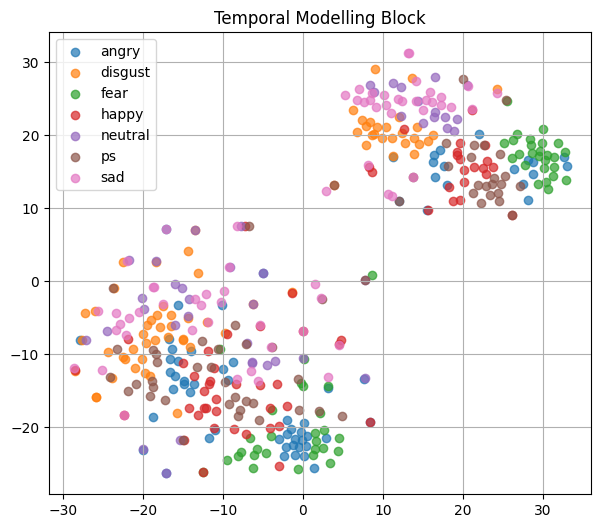

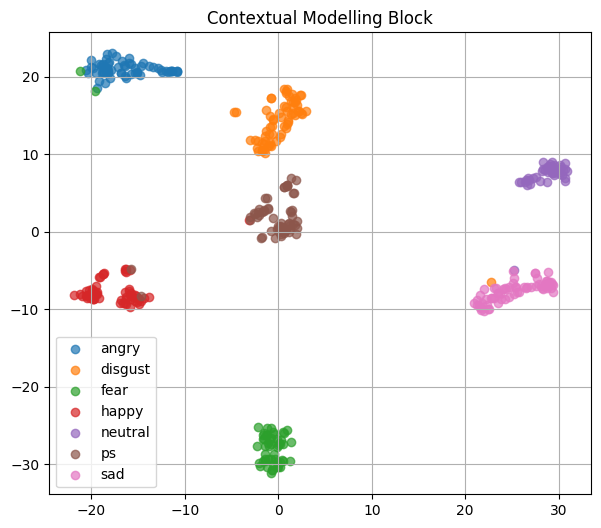

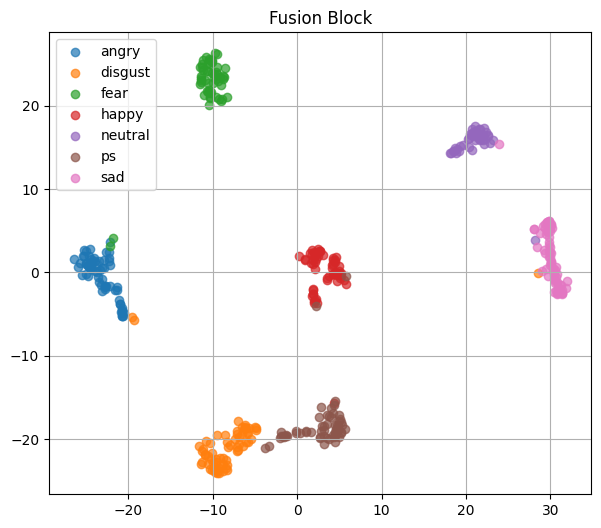

In [16]:
class_names = dataset.label_encoder.classes_

plot_tsne(temporal_feats, labels_all,
          "Temporal Modelling Block", class_names)

plot_tsne(contextual_feats, labels_all,
          "Contextual Modelling Block", class_names)

plot_tsne(fusion_feats, labels_all,
          "Fusion Block", class_names)
